In [ ]:
# Uninstall any existing TensorFlow
!pip uninstall tensorflow -y

# Install TensorFlow 2.17
!pip install tensorflow==2.17.0

# Install Keras, Keras Tuner, and other required libraries
!pip install keras keras-tuner scikit-learn matplotlib scikit-image imblearn

# Verify the installation
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from sklearn.preprocessing import LabelBinarizer

print("TensorFlow version:", tf.__version__)
print("Keras Tuner version:", kt.__version__)



Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
  Using cached tensorflow-2.17.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
Using cached tensorflow-2.17.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (601.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.17.0 which is incompatible.
  Using cached keras_tuner-1.4.7-py3-none-any.whl.metadata (5.4 kB)
  Using cached imblearn-0.0-py2.py3-none-any.whl.metadata (355 bytes)
Using cached keras_tuner-1.4.7-py3-none-any.whl (129 kB)
Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
TensorFlow version: 2.17.0
Keras Tuner version: 1.4.7


In [ ]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization ,Activation, GlobalAveragePooling2D,LayerNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, AdamW, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2,l1_l2
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,ConfusionMatrixDisplay, roc_auc_score, precision_recall_curve
from google.colab import drive
from sklearn.model_selection import StratifiedKFold

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load images and labels
def load_images_and_labels(folder_path, image_size=(224, 224)):
    images = []
    labels = []
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        try:
            image = imread(file_path)
            if image is not None:
                image = resize(image, image_size, anti_aliasing=True)
                # Normalize the image
                image =normalize_image(image)

                images.append(image)
                label = file.rsplit('_', 1)[0]
                labels.append(label)
        except Exception as e:
            print(f"Error loading {file}: {e}")
    return np.array(images), np.array(labels)


In [ ]:
def normalize_image(image):
    # Normalize the image to scale pixel values to [0, 1]
    return image / 255.0


In [ ]:
def compute_mean_std(images):
    mean, variance = tf.nn.moments(images, axes=[0, 1, 2])
    stddev = tf.sqrt(variance) + 1e-7  # Add small constant to avoid division by zero
    return mean, stddev


In [ ]:
def standardize_images(images, mean, stddev):
    return (images - mean) / stddev


In [ ]:
# Load dataset
folder_path ='/content/drive/MyDrive/Colab Notebooks/Model/Data/Mendeley/classificacao_binaria/images_new'

images, labels = load_images_and_labels(folder_path)

# Check the shape of images and labels
print("Shape of images:", images.shape)
print("Shape of labels:", labels.shape)




Shape of images: (7919, 224, 224, 3)
Shape of labels: (7919,)


In [ ]:
# Compute mean and stddev from the dataset
mean, stddev = compute_mean_std(images)

# Convert tensors to NumPy arrays
mean_np = mean.numpy()
stddev_np = stddev.numpy()
print("Mean:", mean_np)
print("Stddev:", stddev_np)

# Save to files
np.save('/content/drive/MyDrive/Colab Notebooks/Model/mean.npy', mean_np)
np.save('/content/drive/MyDrive/Colab Notebooks/Model/stddev.npy', stddev_np)


In [ ]:
mean_np=np.load('/content/drive/MyDrive/Colab Notebooks/Model/mean.npy')
stddev_np=np.load('/content/drive/MyDrive/Colab Notebooks/Model/stddev.npy')
# Standardize images using computed mean and stddev
standardized_images_np = standardize_images(images, mean_np, stddev_np)


In [ ]:
# Encode labels
label_encoder = LabelEncoder()
lbl_encoded = label_encoder.fit_transform(labels)


num_classes = len(label_encoder.classes_)

In [ ]:
# Calculate class weights based on the original labels
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(lbl_encoded), y=lbl_encoded)
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
# Best hyperparameters
best_hyperparameters = {
    'conv1_filters': 32,
    'conv1_dropout': 0.1,
    'conv2_dropout_0': 0.1,
    'conv2_dropout_1': 0.2,
    'conv3_dropout_0': 0.2,
    'conv3_dropout_1': 0.1,
    'fc_units_0': 384,
    'fc_dropout_0': 0.3,
    'fc_units_1': 448,
    'fc_dropout_1': 0.5,
    'fc_units_2': 512,
    'fc_dropout_2': 0.6,
    'learning_rate': 6.668164718461625e-05,
    'weight_decay': 1.5185965795089264e-05
}

def build_final_model():
    model = Sequential()

    # Block 1
    model.add(Conv2D(
        filters=best_hyperparameters['conv1_filters'],
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
        input_shape=(224, 224, 3),
        kernel_regularizer=l1_l2(
            l1=1e-7,
            l2=1e-4)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=best_hyperparameters['conv1_dropout']))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    for i in range(2):  # Two Conv2D layers
        model.add(Conv2D(128,
            kernel_size=(3, 3),
            activation='relu',
            padding='same',
            kernel_regularizer=l1_l2(
                l1=1e-7,
                l2=1e-4)
        ))
        model.add(BatchNormalization())
        model.add(Dropout(rate=best_hyperparameters[f'conv2_dropout_{i}']))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    for i in range(2):  # Two Conv2D layers
        model.add(Conv2D(256,
            kernel_size=(3, 3),
            activation='relu',
            padding='same',
            kernel_regularizer=l1_l2(
                l1=1e-7,
                l2=1e-4)
        ))
        model.add(BatchNormalization())
        model.add(Dropout(rate=best_hyperparameters[f'conv3_dropout_{i}']))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Fully Connected Layers
    model.add(GlobalAveragePooling2D())

    for i in range(3):  # Three Dense layers
        model.add(Dense(
            units=best_hyperparameters[f'fc_units_{i}'],
            activation='relu',
            kernel_regularizer=l1_l2(
                l1=1e-7,
                l2=1e-4)
        ))
        model.add(Dropout(rate=best_hyperparameters[f'fc_dropout_{i}']))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    # Learning rate and optimizer with weight decay
    lr = best_hyperparameters['learning_rate']
    wd = best_hyperparameters['weight_decay']
    optimizer = AdamW(learning_rate=lr, weight_decay=wd)

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Create and compile the final model with the best hyperparameters
model = build_final_model()

# Model summary to verify the architecture
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 128)       │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │              

 Total params: 1,575,489 (6.01 MB)

 Trainable params: 1,573,889 (6.00 MB)

 Non-trainable params: 1,600 (6.25 KB)

In [ ]:
# Number of folds for cross-validation
n_splits = 4
best_val_accuracy=0.0
# Prepare stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
best_model_path = '/content/drive/MyDrive/Colab Notebooks/Model/BestModelwithCrossVal.keras'
# Data augmentation configuration for the minority class
mindatagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.02,
    height_shift_range=0.02,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Initialize lists to collect validation scores and metrics
validation_accuracies = []
confusion_matrices = []
classification_reports = []
roc_auc_scores = []
precision_recall_values = []
histories = []

for fold, (train_index, val_index) in enumerate(skf.split(standardized_images_np, lbl_encoded)):
    print(f"Processing fold {fold + 1}/{n_splits}")

    # Split the data into training and validation sets for this fold
    X_train_fold, X_val_fold = standardized_images_np[train_index], standardized_images_np[val_index]
    y_train_fold, y_val_fold = lbl_encoded[train_index], lbl_encoded[val_index]

    # Separate the minority and majority class in the training set of this fold
    minority_images = X_train_fold[y_train_fold == 0]
    minority_labels = y_train_fold[y_train_fold == 0]
    majority_count = np.sum(y_train_fold == 1)

    # Calculate the number of additional samples needed for the minority class
    additional_samples_needed = int(0.05 * majority_count) + (majority_count - len(minority_labels))

    # Create a data generator for the minority class
    minority_generator = mindatagen.flow(
        minority_images,
        minority_labels,
        batch_size=32
    )

    # Train the model on the augmented training set
    model = build_final_model()

    # Determine number of batches needed
    n_batches = additional_samples_needed // 32

    for batch in range(n_batches):
        imgs, lbls = next(minority_generator)
        X_train_batch = np.concatenate([X_train_fold, imgs])
        y_train_batch = np.concatenate([y_train_fold, lbls])

        # Train the model on the batch
        model.fit(
            X_train_batch, y_train_batch,
            epochs=1,  # Train for one epoch at a time
            batch_size=32,
            verbose=1
        )

    # After augmenting, train on the original data again
    history=model.fit(
        X_train_fold, y_train_fold,
        epochs=10,  # Adjust epochs as needed
        batch_size=32,
        validation_data=(X_val_fold, y_val_fold),
        class_weight=class_weights_dict,
        callbacks=[
            EarlyStopping(patience=3, verbose=1),
            ReduceLROnPlateau(patience=2, verbose=1)
        ],
        verbose=1
    )
    # Store the history object
    histories.append(history)

    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    validation_accuracies.append(val_accuracy)
    print(f"Fold {fold + 1} - Validation Accuracy: {val_accuracy} - Validation Loss: {val_loss}")

    # Check if this model is the best so far
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = model
        best_model.save(best_model_path)
        print(f"New best model found for fold {fold + 1}. Saved to {best_model_path}")

    # Predictions on the validation set
    y_val_pred = model.predict(X_val_fold).round().astype(int)

    # Confusion Matrix
    cm = confusion_matrix(y_val_fold, y_val_pred)
    confusion_matrices.append(cm)

    # Classification Report
    report = classification_report(y_val_fold, y_val_pred, output_dict=True)
    classification_reports.append(report)

    # ROC-AUC Score
    roc_auc = roc_auc_score(y_val_fold, y_val_pred)
    roc_auc_scores.append(roc_auc)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_val_fold, y_val_pred)
    precision_recall_values.append((precision, recall))

# Save the best model
print(f"Best model saved to {best_model_path}")

Processing fold 1/4


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.7593 - loss: 0.7071
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8258 - loss: 0.5780
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8551 - loss: 0.5221
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8584 - loss: 0.4869
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8774 - loss: 0.4601
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8898 - loss: 0.4472
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8957 - loss: 0.4200
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8893 - loss: 0.4433
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9068 - loss: 0.4027
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9067 - loss: 0.3944
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9119 - loss: 0.3890
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9112 - loss: 0.3765
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9041 - loss: 0.3841
187/187 ━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step - accuracy: 0.7071 - loss: 0.7757
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8416 - loss: 0.5597
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8518 - loss: 0.5118
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8657 - loss: 0.4986
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8838 - loss: 0.4639
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8940 - loss: 0.4437
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8943 - loss: 0.4312
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9036 - loss: 0.4092
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9009 - loss: 0.4159
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9084 - loss: 0.3890
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9169 - loss: 0.3836
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9197 - loss: 0.3660
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9221 - loss: 0.3639
187/187 ━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 27s 74ms/step - accuracy: 0.7364 - loss: 0.7350
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8357 - loss: 0.5641
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8629 - loss: 0.4916
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8769 - loss: 0.4642
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8850 - loss: 0.4368
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8983 - loss: 0.4251
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8995 - loss: 0.4200
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9081 - loss: 0.4014
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9048 - loss: 0.4015
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9162 - loss: 0.3734
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9156 - loss: 0.3754
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9186 - loss: 0.3719
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9232 - loss: 0.3525
187/187 ━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 35s 118ms/step - accuracy: 0.7359 - loss: 0.7109
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8319 - loss: 0.5418
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8526 - loss: 0.5076
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8811 - loss: 0.4675
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8833 - loss: 0.4423
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8840 - loss: 0.4338
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9001 - loss: 0.4025
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9027 - loss: 0.3921
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9088 - loss: 0.3971
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9182 - loss: 0.3705
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9214 - loss: 0.3680
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9250 - loss: 0.3542
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9308 - loss: 0.3458
187/187 ━━

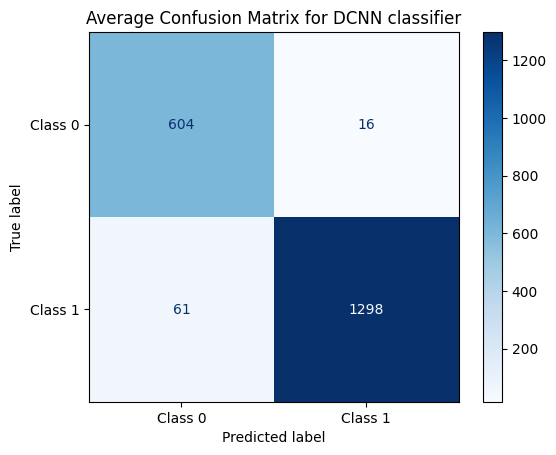

Average Validation Accuracy: 0.9611070901155472
Average Precision: 0.9879767941820166
Average Recall: 0.9551412424793317
Average F1-Score: 0.9711196928249964
Average ROC-AUC Score: 0.9646673954332142
Average Precision-Recall Values:
Precision: [0.68682913 0.98797679 1.        ]
Recall: [1.         0.95514124 0.        ]


In [ ]:


# Calculate the average confusion matrix
average_cm = np.mean(confusion_matrices, axis=0).astype(int)  # Ensure the average confusion matrix has integer values
#Display the average confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=average_cm, display_labels=['Class 0', 'Class 1'])  # Adjust labels as necessary
disp.plot(cmap=plt.cm.Blues)
plt.title('Average Confusion Matrix for DCNN classifier')
plt.show()

# Calculate the average validation accuracy across all folds
average_validation_score = np.mean(validation_accuracies)
print(f"Average Validation Accuracy: {average_validation_score}")

# Calculate the average classification report metrics
average_precision = np.mean([report['1']['precision'] for report in classification_reports])
average_recall = np.mean([report['1']['recall'] for report in classification_reports])
average_f1_score = np.mean([report['1']['f1-score'] for report in classification_reports])
print(f"Average Precision: {average_precision}")
print(f"Average Recall: {average_recall}")
print(f"Average F1-Score: {average_f1_score}")

# Average ROC-AUC Score
average_roc_auc = np.mean(roc_auc_scores)
print(f"Average ROC-AUC Score: {average_roc_auc}")

# Average Precision-Recall Curve
average_precision = np.mean([pr[0] for pr in precision_recall_values], axis=0)
average_recall = np.mean([pr[1] for pr in precision_recall_values], axis=0)
print(f"Average Precision-Recall Values:\nPrecision: {average_precision}\nRecall: {average_recall}")
